## Bristol-Myers Squibb – Molecular Translation

![](https://storage.googleapis.com/kaggle-competitions/kaggle/22422/logos/header.png)

### In this notebook, we are going to cover the following topics

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:skyblue; border:0' role="tab" aria-controls="home"><center>Quick Navigation</center></h2>

* [Aim of the Competition](#1)
* [Data Files Overview/ Quick EDA](#2)
* [Baseline Text Generation Model Creatio to Predict Text for a Given Image](#3)

<a id="1"></a>
<h3 style='background:skyblue; border:0; color:white'><center>Aim of the Competition<center><h3>

* This competition aims at annotating or predicting the right text-string for scanned images.
    * The scanned images are nothing but chemical structures.
    * Annotation/ text that must be predicted for each of the images are the corresponding chemical idenifier (InChI) - https://en.wikipedia.org/wiki/International_Chemical_Identifier.

* As you might have guessed, We are provided with training data - which comprises of scanned images of chemical structures and the corresponding text/annotations which shall be used to develop a system that can help us predict the right text for given a new chemical structure image present in test-data.
* Few considerations are - Images presented both in Training and Test-Data may be very much augmented - having rotated at different angles, presented at various resolutions and even with noise added.

#### With this details about competition - let us get an overview of the data-files in the next step

<a id="2"></a>
<h3 style='background:skyblue; border:0; color:white'><center>Data Files Overview/ Quick EDA<center><h3>

As part of input information provided in competition we have the following data-set

**Train Folder**

**Test Folder**

**train_labels.csv**

**sample_submission.csv**





### Let us first read through train_labels.csv

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
TRAIN_LABELS_PATH = "../input/bms-molecular-translation/train_labels.csv"
df_train_labels = pd.read_csv(TRAIN_LABELS_PATH)
df_train_labels.head()

In [ ]:
df_train_labels.tail()

> We observe that we have two columns in the above file, one with the training data(training image id) and the other wirh corresponding label or text associated with it

### Now lets understand how the train folder, This is arranged in a 3-Level folder structure for each image-id, let us convert each of it in to a fully qualified path

### Here is a snippet of the folder structure for first few and last few images

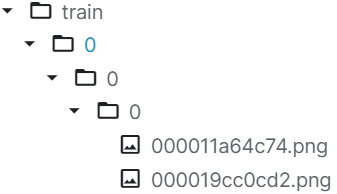

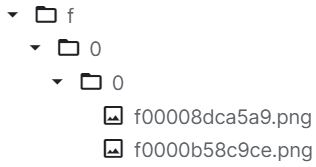

### If we carefully watch the image-id or image-name,first 3 characters in the id represents the folder structure, so using this lets construct the fully qualified image path for each image using below code

In [ ]:
fully_qualified_path = "../input/bms-molecular-translation/train/{}/{}/{}/{}.png"
convert_image_id_to_path = lambda image_id_details :fully_qualified_path.format(image_id_details[0], image_id_details[1], image_id_details[2], image_id_details) 

### Let's create a new column in the above dataframe involving the path of image

In [ ]:
df_train_labels['image_path']=df_train_labels['image_id'].apply(convert_image_id_to_path)

In [ ]:
df_train_labels.head()

#### Similar Approach goes with test file image-id and images present in test-folder structure

### Quick EDA

In [ ]:
def visualize_train_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind + 1)
        image = cv2.imread(convert_image_id_to_path(image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label[:30]}...", fontsize=10)
        plt.axis("off")
    
    plt.show()
tmp_df = df_train_labels[:9]
image_ids = tmp_df['image_id']
labels = tmp_df["InChI"].values
visualize_train_batch(image_ids, labels)

In [ ]:
print('Length of training-data:',len(df_train_labels))
print('Number of unique chemical identifier:',len(df_train_labels['InChI'].value_counts().index))
print('Max count of any chemical identifier in trainign data:',max(df_train_labels['InChI'].value_counts().values))

In [ ]:
h_shape=[]
w_shape=[]
aspect_ratio=[]
for idx,image_id in enumerate(df_train_labels.image_id.values[:1000]):
    image = cv2.imread(df_train_labels['image_path'][idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h_shape.append(image.shape[0])
    w_shape.append(image.shape[1])
    aspect_ratio.append(1.0 * (image.shape[1] / image.shape[0]))
plt.figure(figsize=(12, 12))
plt.subplots_adjust(top = 0.5, bottom=0.01, hspace=1, wspace=0.4)
plt.subplot(2, 2, 1)
plt.hist(np.array(h_shape) * np.array(w_shape), bins=50)
plt.xticks(rotation=45)
plt.title("Area Image Distribution", fontsize=14)
plt.subplot(2, 2, 2)
plt.hist(h_shape, bins=50)
plt.title("Height Image Distribution", fontsize=14)
print()
plt.subplot(2, 2, 3)
plt.hist(w_shape, bins=50)
plt.title("Width Image Distribution", fontsize=14)
plt.subplot(2, 2, 4)
plt.hist(aspect_ratio, bins=50)
plt.title("Aspect Ratio Distribution", fontsize=14);

<a id="3"></a>
<h3 style='background:skyblue; border:0; color:white'><center>Baseline Text Generation Model Creatio to Predict Text for a Given Image<center><h3>

### Let us now get into Model Development - which involves feature extraction and using them for training with labeled texts to help the model predict texts for newer images with their feature-set

In [ ]:
# tensorflow version
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras version
import keras
print('keras: %s' % keras.__version__)

In [ ]:
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
 
# extract features from each image
def extract_features():
    
 # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # summarize
    print(model.summary())
 # extract features from each image
    features = dict()
    for idx,name in enumerate(df_train_labels['image_path'].values[:100]):
        filename = name
        image = load_img(filename, target_size=(224, 224))
         # convert the image pixels to a numpy array
        image = img_to_array(image)
         # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
         # prepare the image for the VGG model
        image = preprocess_input(image)
         # get features
        feature = model.predict(image, verbose=0)
         # store feature
        features[df_train_labels['image_id'][idx]] = feature
        #print('>%s' % name)
    return features

features = extract_features()
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))

In [ ]:
# extract texts for images
def load_text():
    mapping = dict()
    for idx,text in enumerate(df_train_labels['InChI'].values[:100]):
        mapping[df_train_labels['image_id'][idx]]=text
    return mapping

def to_vocabulary(descriptions):
    all_desc = set()
    for key,value in descriptions.items():
        all_desc.update([value])
    return all_desc
texts = load_text()
vocabulary  = to_vocabulary(texts)
print('Loaded: %d ' % len(texts))
print('Vocabulary Size: %d' % len(vocabulary))

### Work in progress....

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()
import Levenshtein

In [ ]:
test = pd.read_csv('../input/bms-molecular-translation/sample_submission.csv')

In [ ]:
train=df_train_labels
train['InChI_list'] = train['InChI'].progress_apply(lambda x: x.split('/'))
train['InChI_length'] = train['InChI_list'].progress_apply(len)
InChI_df = train['InChI_list'].progress_apply(pd.Series)
train = pd.concat([train, InChI_df.add_prefix('InChI_')], axis=1)
display(train)

In [ ]:
#train.to_pickle('train.pkl')
#test.to_pickle('test.pkl')

In [ ]:
def get_score(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        score = Levenshtein.distance(true, pred)
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score

In [ ]:
mode_concat_string = ''
for i in range(11):
    mode_string = train[f'InChI_{i}'].fillna('nan').mode()[0]
    if mode_string != 'nan':
        if i == 0:
            mode_concat_string += mode_string
        else:
            mode_concat_string += '/' + mode_string
print(mode_concat_string)

y_true = train['InChI'].values
y_pred = [mode_concat_string] * len(train)
score = get_score(y_true, y_pred)
print(score)


In [ ]:
test['InChI'] = mode_concat_string
output_cols = ['image_id', 'InChI']
display(test[output_cols])
test[output_cols].to_csv('submission.csv', index=False)